# 1. 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_dir = "trip.csv" 
data = pd.read_csv(data_dir)

target_col = 'fare_amount' 

In [3]:
# 샘플 확인
print("\nSample Data:")
display(data.head(10))


Sample Data:


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
0,Pamela Duffy,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,Debit Card,6,3.34,13.0,2.76,0.0
1,Michelle Foster,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,Debit Card,1,1.80,16.0,4.00,0.0
2,Tina Combs,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,Debit Card,1,1.00,6.5,1.45,0.0
3,Anthony Ray,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,Cash,1,3.70,20.5,6.39,0.0
4,Brianna Johnson,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,Debit Card,1,4.37,16.5,0.00,0.0
5,Justin Smith,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,Debit Card,6,2.30,9.0,2.06,0.0
6,Tonya Moreno,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,Cash,1,12.83,47.5,9.86,0.0
7,Hannah Foley,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,Debit Card,1,2.98,16.0,1.78,0.0
8,Katie Whitney,02/04/2017 4:17:07 PM,02/04/2017 4:29:14 PM,Cash,1,1.20,9.0,0.00,0.0
9,Amanda Jones,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,Cash,1,1.60,13.0,2.75,0.0


# 2. 데이터 전처리

## 결측치 처리

In [4]:
print(data.isnull().sum())

passenger_name           0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
payment_method           0
passenger_count          0
trip_distance            0
fare_amount              3
tip_amount               0
tolls_amount             0
dtype: int64


In [5]:
# 결측치 행 제거
data_cleaned = data.dropna(subset=['fare_amount']).copy()

data = data_cleaned

In [6]:
print(data.isnull().sum())

passenger_name           0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
payment_method           0
passenger_count          0
trip_distance            0
fare_amount              0
tip_amount               0
tolls_amount             0
dtype: int64


## 이상치 탐지 및 처리

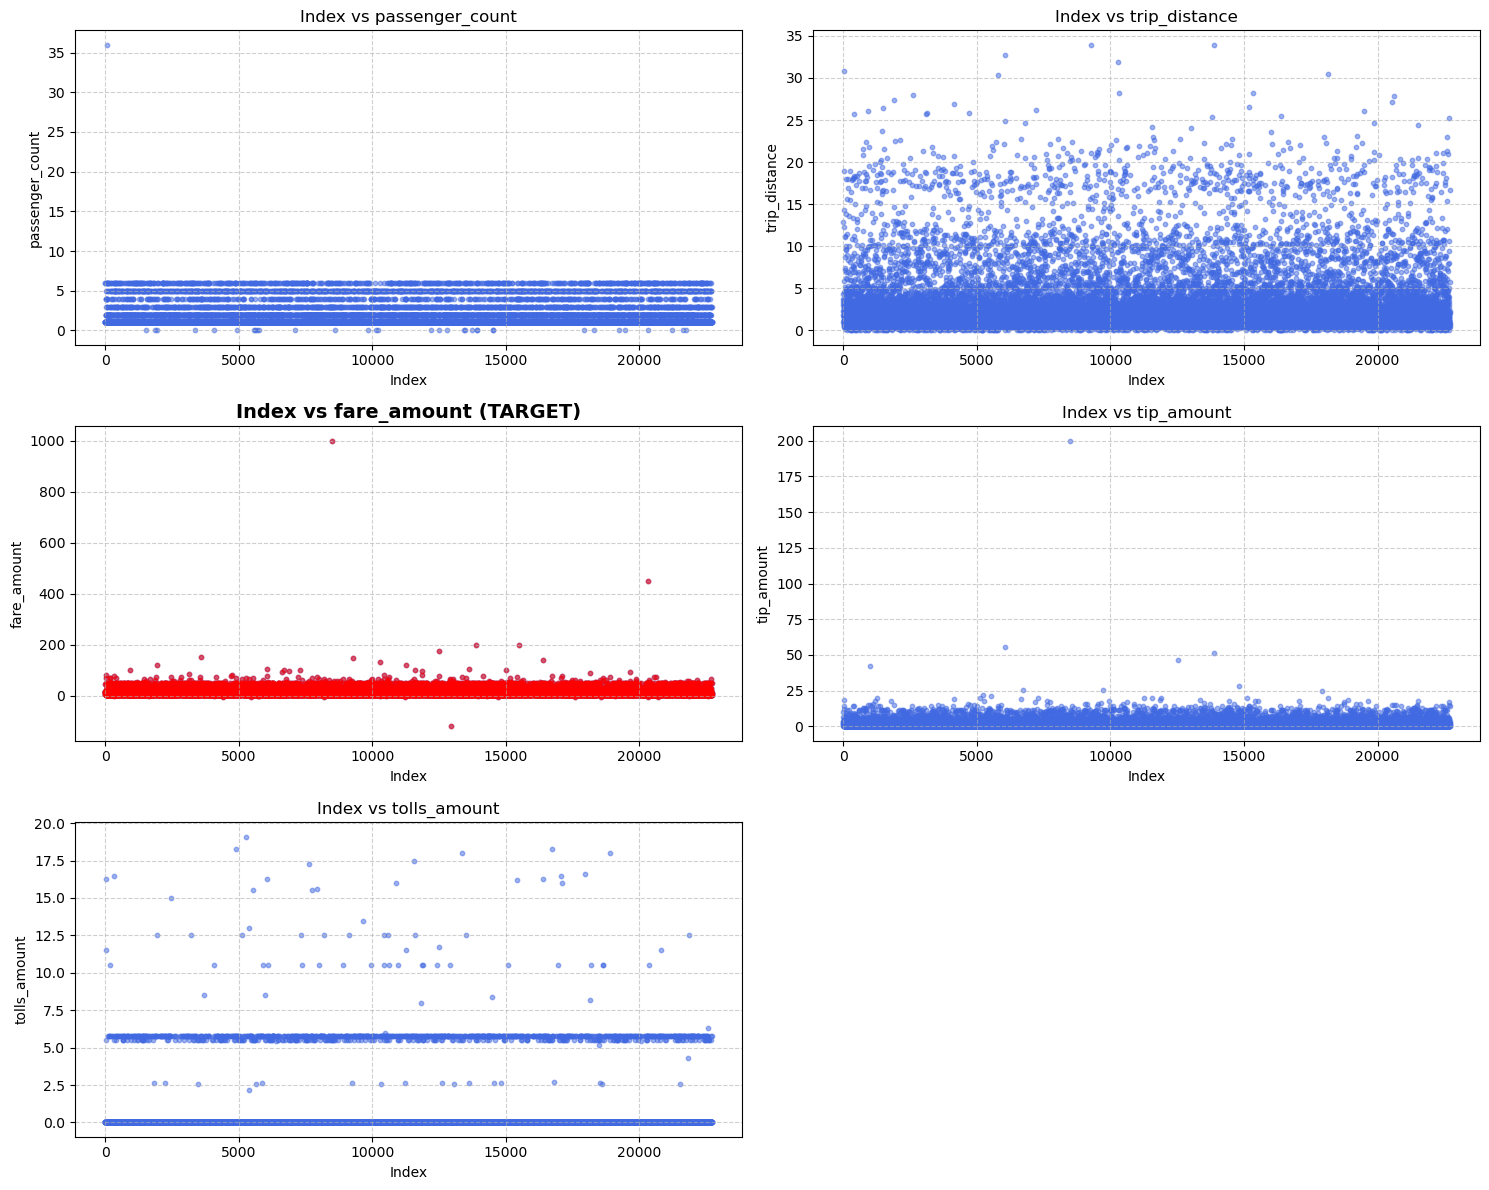

In [7]:
# 스캐터 플롯 그리고 이상치 확인하기
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 2, i)
    
    plt.scatter(data.index, data[col], alpha=0.5, s=10, color='royalblue')
    
    if col == target_col:
        plt.scatter(data.index, data[col], alpha=0.5, s=10, color='red')
        plt.title(f'Index vs {col} (TARGET)', fontsize=14, fontweight='bold')
    else:
        plt.title(f'Index vs {col}')
        
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

- `passenger_count`에서 탑승 정원 5명을 초과한 36명 탑승 정보 관측
- Target으로 설정한 `fare_amount`에서 0보다 낮은 값(환불이나 오류), 위로 솟은 극단값 관측
- `trip_distance`에서 운행 거리가 0인데 요금이 발생한 정보 관측

In [8]:
# 위에서 발견한 이상값 우선 처리
data = data[
    (data['fare_amount'] > 0) &           # 요금은 양수여야 한다.
    (data['trip_distance'] > 0) &         # 거리는 양수여야 한다.
    (data['passenger_count'] > 0) &       # 승객은 최소 1명을 초과해야 한다. 승객 0명인 경우 제외
    (data['passenger_count'] <= 6)        # 승객은 최대 6명 
]

In [9]:
# IQR
Q1 = data['fare_amount'].quantile(0.25)
Q3 = data['fare_amount'].quantile(0.75)
IQR = Q3 - Q1

# 상한선 설정
upper_limit = Q3 + 3.0 * IQR

## 데이터 타입 변환

In [10]:
"""
범주형 및 수치형 변수 식별
- 범주형: payment_method (신용카드, 현금 등)
- 수치형: passenger_count, trip_distance, fare_amount 등
- 날짜형: tpep_pickup_datetime, tpep_dropoff_datetime
"""

# Credit/Debit Card -> Card
data.loc[:, 'payment_method'] = data['payment_method'].replace(['Credit Card', 'Debit Card'], 'Card')

In [11]:
# 날짜형 데이터 변환
data.loc[:, 'tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data.loc[:, 'tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [12]:
# 원-핫 인코딩
data = pd.get_dummies(data, columns=['payment_method'], prefix='pay')

In [13]:
# 결과 확인
print("--- 변환 후 컬럼 목록 ---")
print(data.columns)
print("\n--- 데이터 샘플 ---")
print(data[['pay_Card', 'pay_Cash', 'trip_distance', 'fare_amount']].head())

--- 변환 후 컬럼 목록 ---
Index(['passenger_name', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount',
       'tolls_amount', 'pay_Card', 'pay_Cash'],
      dtype='object')

--- 데이터 샘플 ---
   pay_Card  pay_Cash  trip_distance  fare_amount
0      True     False           3.34         13.0
1      True     False           1.80         16.0
2      True     False           1.00          6.5
3     False      True           3.70         20.5
4      True     False           4.37         16.5


# 3. EDA

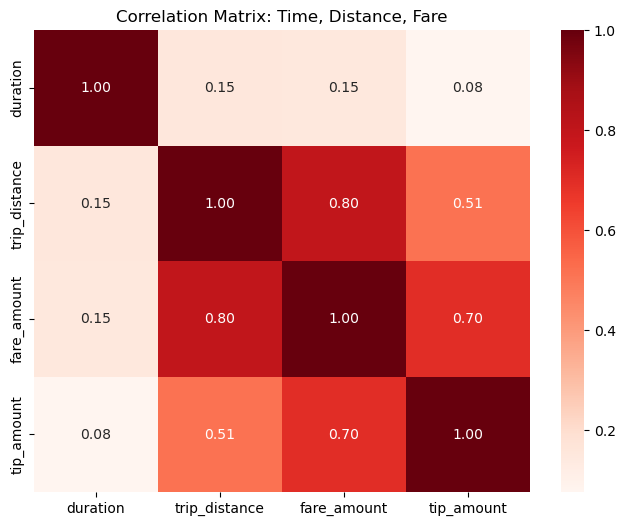

In [14]:
# 택시 승하차 시간 활용 방법에 대한 고민 - 상관관계 활용

# 두 컬럼을 날짜형으로 변환
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

# Duration 계산
data.loc[:, 'duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

# 이상치 필터링 및 상관관계 분석
data = data[(data['duration'] > 0) & (data['duration'] < 1440)].copy()
corr_features = ['duration', 'trip_distance', 'fare_amount', 'tip_amount']
correlation_matrix = data[corr_features].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt=".2f")
plt.title('Correlation Matrix: Time, Distance, Fare')
plt.show()

- `trip_distance`와 `fare_amount` 사이의 상관계수는 약 0.75로 높은 상관관계를 가지고 있다. 주행 거리가 길어질 수록 요금도 올라가는 선형 관계에 있다.
- `fare_amount`와 `tip_amount`도 0.69의 높은 상관관계를 가지고 있다. 요금이 비쌀수록 더 많은 팁을 준다고 볼 수 있다.
- `duration`은 `trip_distance`나 `trip_amount`와 낮은 상관관계를 가지고 있다. 오래 탄다고 멀리 가거나 비싼 요금을 지불하는 것만은 아니라는 것으로 해석할 수 있다.

## 단변량 분석

In [ ]:
# 기술통계량
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'duration']

print(data[numeric_cols].describe())

       passenger_count  trip_distance   fare_amount    tip_amount  \
count     22500.000000   22500.000000  22500.000000  22500.000000   
mean          1.645911       2.932587     12.974094      1.830859   
std           1.285606       3.655908     12.668246      2.767554   
min           1.000000       0.010000      0.010000      0.000000   
25%           1.000000       1.000000      6.500000      0.000000   
50%           1.000000       1.630000      9.500000      1.360000   
75%           2.000000       3.092500     14.500000      2.450000   
max           6.000000      33.960000    999.990000    200.000000   

           duration  
count  22500.000000  
mean      17.065238  
std       61.568071  
min        0.016667  
25%        6.733333  
50%       11.233333  
75%       18.450000  
max     1439.550000  


- 위에서 만든 변수 `duration(주행 시간)`을 보면 평균적으로 17분정도 소요되지만, 최소 0.01초부터 최대 1439초까지 범위가 다양하다. 이는 거리뿐만 아니라 시간도 요금에 큰 영향을 줄 변수가 될 수 있음을 의미한다.

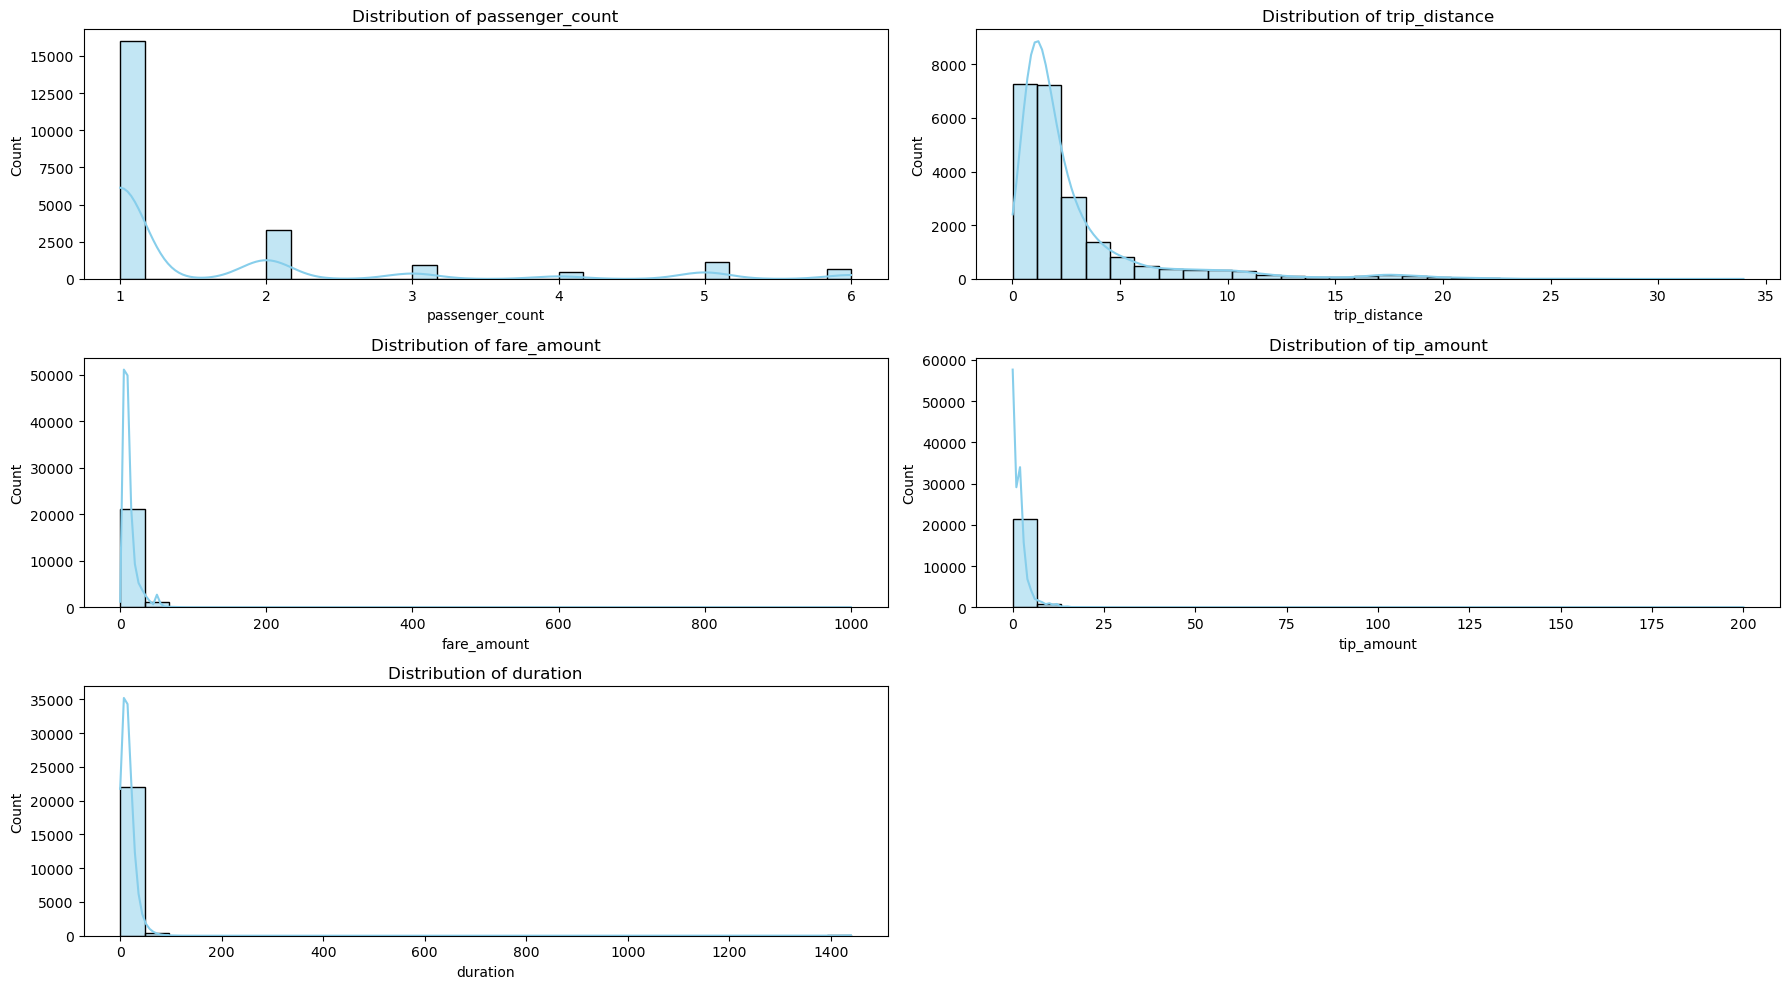

In [30]:
plt.figure(figsize=(18, 10)) 
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 2, i) 
    sns.histplot(data[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

- `fare_amount`, `trip_distance`, `duration` 모두 왜도가 왼쪽으로 치중되어있다. 대부분 택시 요금은 $10~15 내외의 단거리 위주이며, 고액이나 장거리 주행은 드물다는 것을 의미한다.
- `fare_amount`에서 $1000에 가까운 극단적인 고액이 관찰된다.

Card 결제 빈도: 11404
Cash 결제 빈도: 11096


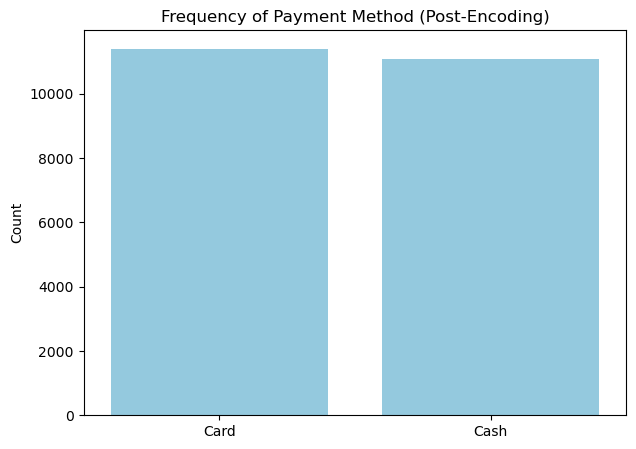

In [ ]:
# 결제 빈도 확인
card_count = data['pay_Card'].sum()
cash_count = data['pay_Cash'].sum()

print(f"Card 결제 빈도: {card_count}")
print(f"Cash 결제 빈도: {cash_count}")

plt.figure(figsize=(7, 5))
sns.barplot(x=['Card', 'Cash'], y=[card_count, cash_count], color='skyblue')
plt.title('Frequency of Payment Method (Post-Encoding)')
plt.ylabel('Count')
plt.show()

- 카드와 현금의 비중이 거의 1:1로 균형잡힌 모습을 볼 수 있다.

## 이변량 분석

In [33]:
# 극단값 필터링
filtered_data = data[
    (data['duration'] > 0) & (data['duration'] < 100) &        
    (data['trip_distance'] > 0) & (data['trip_distance'] < 40) & 
    (data['fare_amount'] > 0) & (data['fare_amount'] < 150)      
].copy()

Text(0, 0.5, 'Fare Amount')

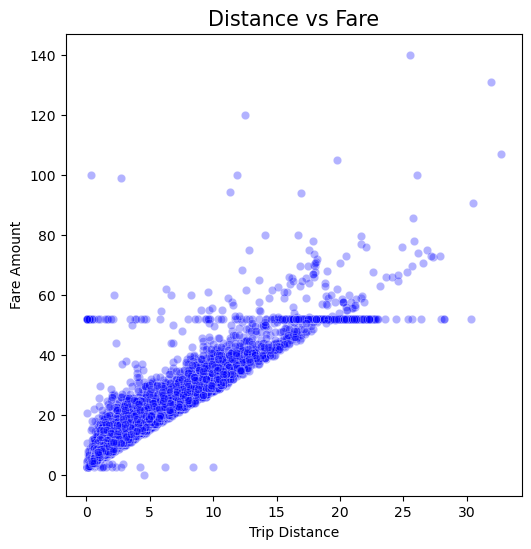

In [56]:
# 주행 거리 vs 요금 
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(data=filtered_data, x='trip_distance', y='fare_amount', alpha=0.3, color='blue')
plt.title('Distance vs Fare', fontsize=15)
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')

- 산점도에서 뚜렷한 우상향 직선 형태가 보인다. 거리가 늘어남에 따라 요금이 일정하게 증가하는 관계를 가지고 있음을 볼 수 있다.

Text(0, 0.5, 'Fare Amount')

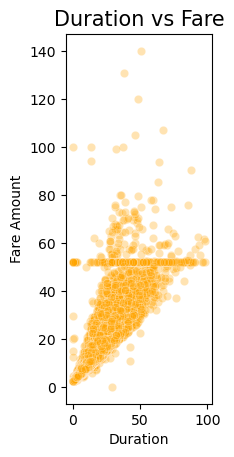

In [55]:
# 주행 시간 vs 요금
plt.subplot(1, 3, 2)
sns.scatterplot(data=filtered_data, x='duration', y='fare_amount', alpha=0.3, color='orange')
plt.title('Duration vs Fare', fontsize=15)
plt.xlabel('Duration')
plt.ylabel('Fare Amount')

- 거리 그래프보다는 넓게 퍼지긴 했지만, 동일하게 우상향 하는 모습을 확인할 수 있다. 
- 주행시간과 요금도 양의 관계에 있지만, 거리만큼 큰 요인은 아님을 알 숭 ㅣㅆ다.

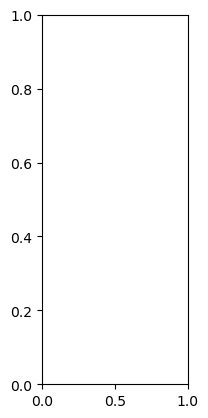

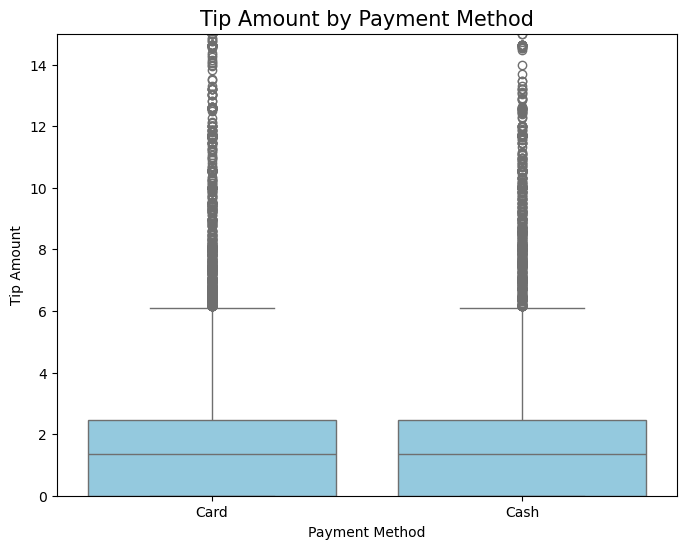

In [ ]:
# 결제 수단 vs 팁 금액
plt.subplot(1, 3, 3)
filtered_data['temp_method'] = np.where(filtered_data['pay_Card'], 'Card', 'Cash')

plt.figure(figsize=(8, 6))

sns.boxplot(
    data=filtered_data, 
    x='temp_method', 
    y='tip_amount',   
    color='skyblue'  
);

plt.title('Tip Amount by Payment Method', fontsize=15)
plt.ylim(0, 15)  
plt.xlabel('Payment Method')
plt.ylabel('Tip Amount')

plt.show()

- 박스플롯에서 `Card`와 `Cash`의 상자 모양이 거의 비슷하게 나타난다. 결제 수단에 관계 없이 팁 금액은 비슷하다고 볼 수 있다.

In [53]:
summary = filtered_data.groupby('temp_method')['tip_amount'].agg(['count', 'mean'])
print(summary)

             count      mean
temp_method                 
Card         11369  1.815638
Cash         11070  1.816947


- `Card`와 `Cash` 두 그룹 모두 평균 팁이 $1.8 정도로 나왔다.
- 요금을 예측할 때는 `payment_method`보다 `trip_distancr`나 `duration`이 더 강력한 예측 변수가 될 수 있다.

## 다변량 분석

In [59]:
if 'payment_method' not in data.columns:
    data['payment_group'] = np.where(data['pay_Card'], 'Card', 'Cash')
else:
    data['payment_group'] = data['payment_method'].replace(['Credit Card', 'Debit Card'], 'Card')

# 시간/요일 데이터 추출
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['hour'] = data['tpep_pickup_datetime'].dt.hour
data['day_name'] = data['tpep_pickup_datetime'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 이상치 필터링
filtered_data = data[
    (data['trip_distance'] > 0) & (data['trip_distance'] < 40) &
    (data['fare_amount'] > 0) & (data['fare_amount'] < 150)
].copy()

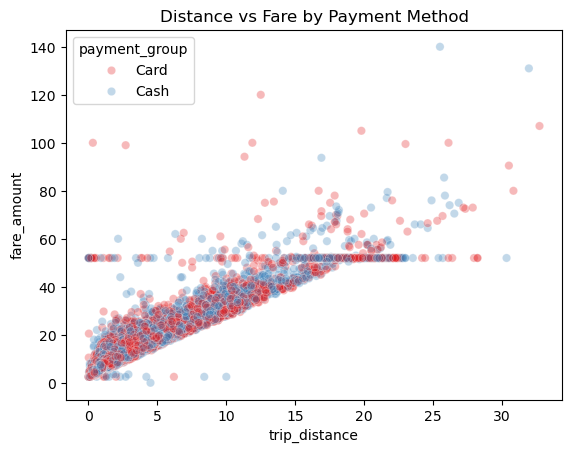

In [ ]:
# 거리 x 요금 x 결제 수단 산점도
sns.scatterplot(data=filtered_data, x='trip_distance', y='fare_amount', 
                hue='payment_group', alpha=0.3, palette='Set1')
plt.title('Distance vs Fare by Payment Method')
plt.show()

- 카드와 현금 데이터가 하나의 직선 위에 겹쳐서 나타난다. 이는 결제 수단끼리 상관이 거의 없다는 것을 의미한다.
- 직선에서 크게 벗어난 점들을 색깔별로 확인해보면 '현금 승객 중 높은 요금을 내는 경우는 바가지 or 오류 아닐까?' 하는 등의 가설을 세울 수 있다.

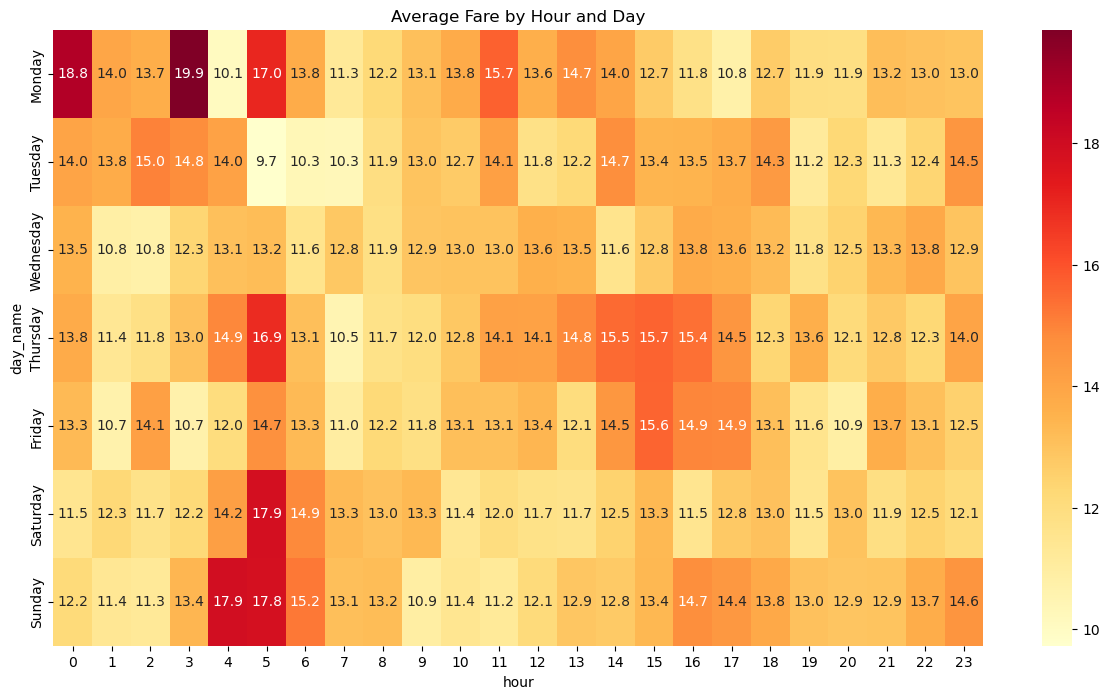

In [ ]:
# 요일 x 시간 x 요금 히트앱
pivot_table = filtered_data.pivot_table(values='fare_amount', 
                                        index='day_name', 
                                        columns='hour', 
                                        aggfunc='mean')
pivot_table = pivot_table.reindex(day_order)

plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt=".1f")
plt.title('Average Fare by Hour and Day')
plt.show()

- 히트맵에서 빨갛게 나오는 부분은 평균 요금이 높은 구간으로, 평일 퇴근 시간이나 금/토 심야 시간에 해당한다. 
- 평일과 주말의 패턴이 다른 것을 확인할 수 있다.
  - 평일은 출퇴근 시간대에 변동이 크다.
  - 주말은 특정 피크 없이 낮 시간대 전반에 걸쳐 요금이 고르게 분포하거나, 토요일 밤에 몰리는 경향이 있다.